In [1]:
# modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import chardet
import csv
import os
import matplotlib.dates as mdates
from IPython.display import Image

## Inserez les chemins vers le fichiers CSV:

In [2]:
# Chemin vers image 
chemin_image = './raw_data/point13_29_07_15/point13_schema.png'

# Chemin vers la data des capteurs
chemin_capteur_pression = "./raw_data/point13_29_07_15/p505_Hobo33_29_07_15.csv"
chemin_capteur_temperatures = "./raw_data/point13_29_07_15/t503_hobo1_29_07_15.csv"
chemin_pressure_sensor = "./configuration/pressure_sensors/P508.csv"

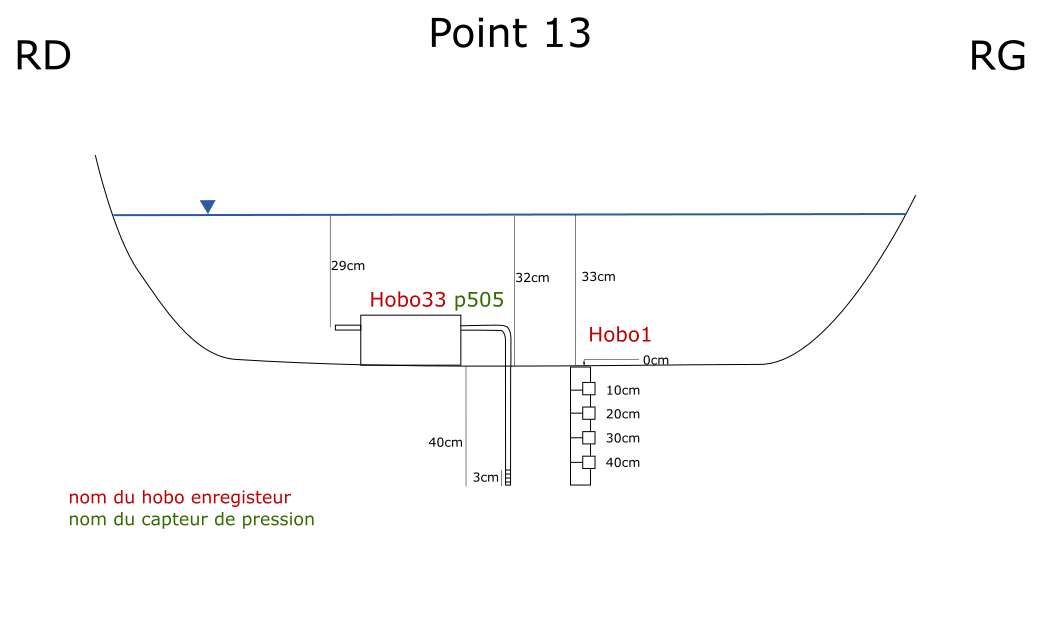

In [3]:
# Affichage de l'image
Image(filename = chemin_image)

In [13]:
def read_csv (chemin_fichier):

    #Detecter separateur
    with open(chemin_fichier, 'r') as file:
        sniffer = csv.Sniffer()
        sample_data = file.read(1024)
        detecter_separateur = (sniffer.sniff(sample_data).delimiter)

    if "Titre" in open(chemin_fichier).readline():
        data_frame = pd.read_csv(chemin_fichier, sep=detecter_separateur, skiprows=1)
    else:
        data_frame = pd.read_csv(chemin_fichier, sep=detecter_separateur)

    return data_frame    

In [14]:
# Definition de Data Frames

capteur_pression = read_csv(chemin_capteur_pression)

capteur_temperatures = read_csv(chemin_capteur_temperatures)

pressure_sensor = read_csv(chemin_pressure_sensor)

In [17]:
capteur_pression.sample(5)

,#,"Date Heure, GMT+02:00","Tension, V (LGR S/N: 10117169, SEN S/N: 10117169)","Temp., °C (LGR S/N: 10117169, SEN S/N: 10117169)"
140,141,07/25/15 01:00:00 AM,0.57631,17.629
206,207,07/25/15 05:30:00 PM,0.57265,16.439
260,261,07/26/15 07:00:00 AM,0.57326,13.858
543,544,07/29/15 05:45:00 AM,0.55006,14.170
390,391,07/27/15 03:30:00 PM,0.56410,15.629


In [18]:
capteur_temperatures.sample(5)

,#,"Date Heure, GMT+02:00","Temp., °C (LGR S/N: 10117154, SEN S/N: 10117154)","Temp., °C (LGR S/N: 10117154, SEN S/N: 10117154).1","Temp., °C (LGR S/N: 10117154, SEN S/N: 10117154).2","Temp., °C (LGR S/N: 10117154, SEN S/N: 10117154).3"
561,562,07/29/15 08:45:00 AM,14.697,14.768,15.247,15.557
200,201,07/25/15 02:30:00 PM,16.892,16.654,16.987,17.082
481,482,07/28/15 12:45:00 PM,15.390,15.247,15.605,15.819
258,259,07/26/15 05:00:00 AM,15.772,15.963,16.534,16.773
539,540,07/29/15 03:15:00 AM,14.984,14.984,15.390,15.652


In [19]:
pressure_sensor

,Sensor_Name,P508
0,Datalogger,Hobo
1,Calibration_Date,2016/01/12 10:10:10
2,Intercept,1.210344
3,dU/dH,-1.462495
4,dU/dT,0.001474
5,Sigma_Meas_P,0.01


In [20]:
def nombre_de_valeurs_manquantes(capteur):
    
    nombre_de_valeurs_manquantes = capteur.isnull().sum()
    nombre_de_valeurs_manquantes[0:6] 


    return nombre_de_valeurs_manquantes

nombre_de_valeurs_manquantes_pression = nombre_de_valeurs_manquantes(capteur_pression)
print(nombre_de_valeurs_manquantes_pression)

nombre_de_valeurs_manquantes_temperature = nombre_de_valeurs_manquantes(capteur_temperatures)
print(nombre_de_valeurs_manquantes_temperature)

#                                                    0
Date Heure, GMT+02:00                                0
Tension, V (LGR S/N: 10117169, SEN S/N: 10117169)    0
Temp., °C (LGR S/N: 10117169, SEN S/N: 10117169)     0
dtype: int64
#                                                     0
Date Heure, GMT+02:00                                 0
Temp., °C (LGR S/N: 10117154, SEN S/N: 10117154)      0
Temp., °C (LGR S/N: 10117154, SEN S/N: 10117154).1    0
Temp., °C (LGR S/N: 10117154, SEN S/N: 10117154).2    0
Temp., °C (LGR S/N: 10117154, SEN S/N: 10117154).3    0
dtype: int64


In [70]:
#Supression de colonnes inutiles

if "#" in capteur_pression.columns:
    capteur_pression = capteur_pression.drop("#", axis=1)
    
if "#" in capteur_temperatures.columns:
    capteur_temperatures = capteur_temperatures.drop("#", axis=1)
